In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT #Importing simple controls
import csv

## Preprocess Environment


In [2]:
from gym.wrappers import GrayScaleObservation #GrayScale convert the color frames to gray
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv #Import Vectorization Wrappers
from matplotlib import pyplot as plt #Matplotlib to show the impact of frames stacking
import datetime

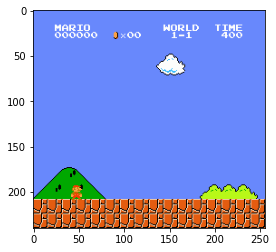

In [3]:
#1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
state = env.reset()
plt.imshow(state)

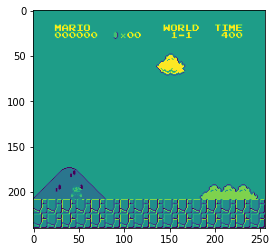

In [4]:
#2. Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
#3. Transform the RGB frames to GrayScale
env = GrayScaleObservation(env, keep_dim=True)
state = env.reset()
plt.imshow(state)

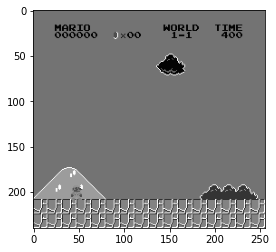

In [5]:
#4 Vectorize the environment
env = DummyVecEnv([lambda: env]) #Parameter: A list of functions that will create the environments 
                                 #(each callable returns a Gym.Env instance when called)
#5 Frame stacking wrapper for vectorized environment
env = VecFrameStack(env, 4, channels_order='last') #2º parameter: number of frames to stack
state = env.reset()
plt.imshow(state[0])

In [6]:
print(state.shape)
a = 240*256*1
b = 240*256*3
print("If we don't use Gray Scale, we'd have to process %d frames, but we will only process %d frames" % (b, a))

(1, 240, 256, 4)
If we don't use Gray Scale, we'd have to process 184320 frames, but we will only process 61440 frames


## Train the AI model

In [7]:
# Import os for file path management
import os 
# Importing PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [8]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [12]:
#Setup where to save the models
CHECKPOINT_DIR = './train'
LOG_DIR = './logs'

In [ ]:
#Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [13]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-4, n_steps = 512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
print(">>>Training starts at ", datetime.datetime.now())
model.learn(total_timesteps=400000, callback=callback)
print(">>>Training ends at ", datetime.datetime.now())

In [ ]:
print(">>>Training ends at ", datetime.datetime.now())

In [16]:
model = PPO.load('./train/best_model_250000')


## Evaluación del modelo

In [14]:
def run(episodes):
    # Start the game 
    #state = env.reset()
    # Loop through the game
    total_rewards = []
    total_scores = []
    total_life_times = []
    for n in range(episodes):
        state = env.reset()
        total_reward = 0
        score = 0
        life_time = 0
        while True: 
            
            action, _ = model.predict(state)
            state, reward, done, info = env.step(action)
            total_reward += int(reward)
            env.render()
            
            if done:            
                score = info[0]["score"]
                life_time = 400 - info[0]["time"]
                break
        
        total_rewards.append(total_reward)
        total_scores.append(score)
        total_life_times.append(life_time)
    
    with open('total_rewards.csv', 'w') as f1:
        writer = csv.writer(f1)
        writer.writerow(total_rewards)
    
    with open('total_scores.csv', 'w') as f2:
        writer = csv.writer(f2)
        writer.writerow(total_scores)
    
    with open('total_life_times.csv', 'w') as f3:
        writer = csv.writer(f3)
        writer.writerow(total_life_times)
            

    print("List of total rewards: ", total_rewards)
    print("List of total score: ", total_scores)
    print("List of total times being alive: ", total_life_times)

### Llamada a la función de evaluación del modelo
En una primera fase de experimentación, se evaluará la calidad del modelo en 30 ejecuciones del mismo

In [17]:
#Llamada a la función de evaluación del modelo
run(30)

List of total rewards:  [1120, 3383, 739, 2277, 1463, 1449, 2297, 2712, 2477, 1111, 1107, 2033, 1822, 732, 1624, 736, 1445, 1641, 1868, 1912, 2128, 2028, 1647, 736, 1636, 1703, 2335, 1895, 2176, 2238]
List of total score:  [0, 1000, 0, 600, 100, 0, 1000, 1200, 400, 200, 0, 0, 400, 0, 100, 200, 100, 100, 200, 100, 400, 500, 0, 400, 0, 600, 900, 200, 100, 400]
List of total times being alive:  [15, 41, 5, 30, 3, 12, 36, 3, 7, 5, 5, 3, 33, 5, 3, 5, 21, 4, 34, 18, 3, 4, 3, 5, 5, 15, 28, 17, 34, 10]


: 